<a href="https://colab.research.google.com/github/cristobalvch/DataScience-For-Business/blob/main/Mainentance-ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA #1: ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRÁCTICO


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=1rcxnQuLqFyn8l9hQmdyp-yxSaXhxJPed"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Predecir Defectus utilizando Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=1WuUNREIQaEKFU9ttcNsP7710otdLZLWY)

![alt text](https://drive.google.com/uc?id=1DIibqHm6xTbegYkFn4kdXm8EjLv60RBs)

![alt text](https://drive.google.com/uc?id=1Z97UmIqEPeV2kwZzxPE0HR4JhqoNezKM)

![alt text](https://drive.google.com/uc?id=1EFKTEdPHsD6Qp8gL0K2E1IFQaOLYkOcu)

![alt text](https://drive.google.com/uc?id=1CChZthmpPSfMVobMsGosn5t0jHByPc7u)

# TAREA #2: IMPORTAR LIBRERÍAS Y DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files 
%matplotlib inline

In [2]:
# Deberás montar tu unidad usando los siguientes comandos:
# Para obtener más información sobre el montaje, consulta en: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


![alt text](https://drive.google.com/uc?id=1FwYiclZhPxv0OtPPeIU50Ped35h85vYG)

![alt text](https://drive.google.com/uc?id=12WX3l8g2aeKggG8z1_7Rg0UFzwqcgUo3)

In [3]:
# Datos que contienen imágenes con defectos con máscara de segmentación 
defect_class_mask_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/6. Maintenance Department/train.csv')


In [4]:
# Datos que contienen imágenes con y sin defectos 
all_images_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/6. Maintenance Department/defect_and_no_defect.csv')


In [5]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...


In [6]:
all_images_df.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


# TAREA #3: VISUALIZAR Y EXPLORAR EL DATASET

In [7]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [8]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


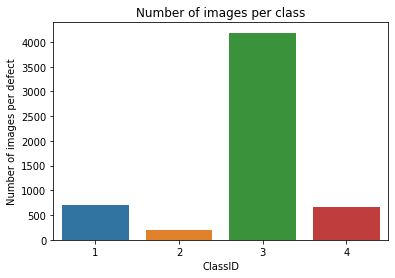

In [9]:
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')
plt.show()

In [10]:
# Algunas imágenes están clasificadas con más de un defecto, exploremos esto con más detalle
# tenemos una imagen con 3 tipos de defectos
# tenemos 272 imágenes con 2 tipos de defectos
# tenemos 5201 imágenes con 1 tipo de defecto
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum().sort_values(ascending=False)

In [11]:
defect_type.head(10)

ImageId
ef24da2ba.jpg    3
4edc8b817.jpg    2
8bc5aeca3.jpg    2
8d2e8b456.jpg    2
adc257b59.jpg    2
6e6b79dc4.jpg    2
4e2c9230d.jpg    2
edfe6ee4c.jpg    2
c7b41dbf4.jpg    2
101648543.jpg    2
Name: mask, dtype: int64

In [12]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

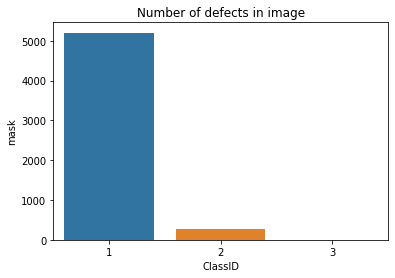

In [13]:
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')
plt.show()

In [14]:
print(f"Dimension de Defet Class Mask Df: {defect_class_mask_df.shape}")
print(f"Dimension de All Images Df: {all_images_df.shape}")

Dimension de Defet Class Mask Df: (5748, 4)
Dimension de All Images Df: (12997, 2)


In [15]:
# Contemos imágenes con y sin defectos
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

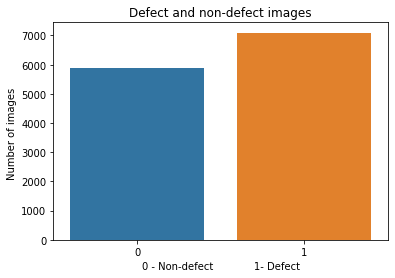

In [16]:
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')
plt.show()

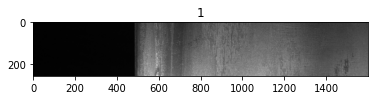

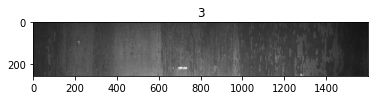

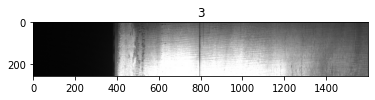

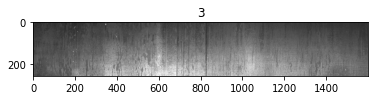

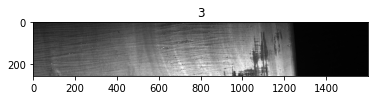

In [17]:
# Visualizar imágenes con defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/MyDrive/Colab Notebooks/6. Maintenance Department/train_images'

for i in range(5):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [18]:
# El archivo de Utilities contiene el código para rle2mask, mask2rle, función de pérdida personalizada y generador de datos personalizados
# dado que los datos proporcionados para la segmentación están en formato RLE (run length encoded), usaremos la siguiente función para convertir el RLE a máscara.
# podemos convertir la máscara nuevamente a RLE para evaluar el rendimiento del modelo (accuracy).
# El código fuente para estas funciones proviene de: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

%cd /content/drive/MyDrive/Colab Notebooks/6. Maintenance Department
from utilities import rle2mask , mask2rle

train_dir = '/content/drive/MyDrive/Colab Notebooks/6. Maintenance Department/train_images'

/content/drive/.shortcut-targets-by-id/1Xn8O6nWcfIx-7HYRPgxomRfHj3V4SgEF/6. Maintenance Department


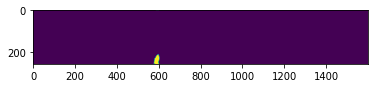

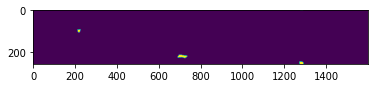

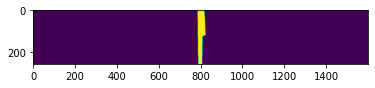

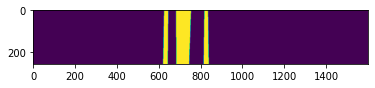

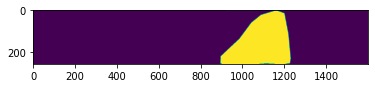

In [24]:
# Intentemos usar rle2mask en un imagen de prueba
for i in range(0,5):
  image_index = i
  mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
  plt.figure()
  plt.imshow(mask)

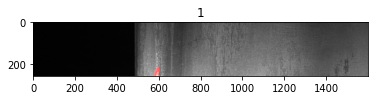

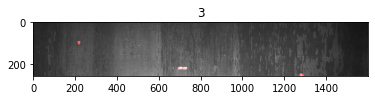

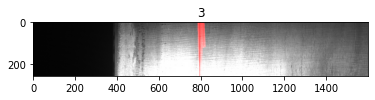

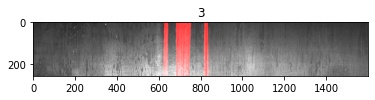

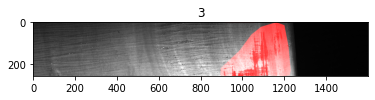

In [37]:
for i in range(5):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 
  #mask = 1,1 1th 1: failure in image, 2th 1: Color Channel] 
  img[mask == 1,0] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

# TAREA #4: ENTENDER LA TEORÍA E INTUICIÓN DETRÁS DE LAS REDES NEURONALES DE CONVOLUCIÓN, RESNETS Y APRENDIZAJE POR TRANSFERENCIA

![alt text](https://drive.google.com/uc?id=1VfMNSEEIjmswlO2YCS2nuTvmqxz2-BHV)

![alt text](https://drive.google.com/uc?id=1k4nFAj3K7qLT0OvpINmiapSRa-IRaxaH)

![alt text](https://drive.google.com/uc?id=1kB1ZJNNahizSNS9N2AdiOGgIKCpDOB7P)

![alt text](https://drive.google.com/uc?id=1lG1qSzWpP9kCM1t9ctX1TKHgdferBvCU)

![alt text](https://drive.google.com/uc?id=17ijGa9o9qIZp_64-EbmDCpHxoc_Sgr4P)

# TAREA #5: CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING PARA DETECTAR PRESENCIA O AUSENCIA DE DEFECTO EN UNA IMAGEN

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [ ]:
# Dividir el dataset (defective and non defective)  en entrenamiento y testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [ ]:
train_dir = '/content/drive/My Drive/Curso de Data Science para Empresas/6. Maintenance Department/train_images/'


In [ ]:
# Crear un generador de imágenes para el conjunto de datos de entrenamiento y validación
# Dividiremos los datos en entrenamiento, validación y testing.
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Crear un generador de datos que escale los datos de 0 a 1 y hacer una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [ ]:
# Crear un generador de datos para imágenes de test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Congelar los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# (CUIDADO ESTO TARDA MUCHO TIEMPO (~90 mins)!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7823
Epoch 00001: val_loss improved from inf to 1.10059, saving model to resnet-weights.hdf5
586/586 [==============================] - 6741s 12s/step - loss: 0.5105 - accuracy: 0.7823 - val_loss: 1.1006 - val_accuracy: 0.4478
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8392
Epoch 00002: val_loss improved from 1.10059 to 0.47946, saving model to resnet-weights.hdf5
586/586 [==============================] - 153s 262ms/step - loss: 0.3659 - accuracy: 0.8392 - val_loss: 0.4795 - val_accuracy: 0.7743
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8667
Epoch 00003: val_loss improved from 0.47946 to 0.42682, saving model to resnet-weights.hdf5
586/586 [==============================] - 154s 262ms/step - loss: 0.3148 - accuracy: 0.8667 - 

In [ ]:
# Guardamos la arquitectura del modelo entrenado para el futuro

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

# TAREA #6: EVALUAR LA EFICACIA DEL MODELO

In [ ]:
with open('/content/drive/My Drive/Curso de Data Science para Empresas/6. Maintenance Department/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargamos el modelo 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/Curso de Data Science para Empresas/6. Maintenance Department/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción (CUIDADO TARDA MUCHO TIEMPO (~10 mins)!)

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


121/121 [==============================] - 22s 183ms/step


In [ ]:
test_predict

array([[4.9002608e-12],
       [1.0891805e-09],
       [9.9976248e-01],
       ...,
       [9.9999952e-01],
       [9.9059874e-01],
       [8.3911499e-07]], dtype=float32)

In [ ]:
# Dado que usamos la función de activación sigmoidea al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa inicialmente para clasificar si la imagen tiene defecto o no
# Luego, estas imágenes (defectuosas) se pasan por la red de segmentación para obtener la ubicación y el tipo de defecto.
# Vamos a elegir 0.01, para asegurarnos de que omitimos las imágenes para que no pasen por la red de segmentación a menos que
# estemos muy seguros de que no tiene ningún defecto y si no estamos seguros, podemos pasar esta imagen a través de la red de segmentación.


predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# como usamos el generador de prueba, limitó las imágenes a 1936, debido al tamaño del lote

original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8734504132231405

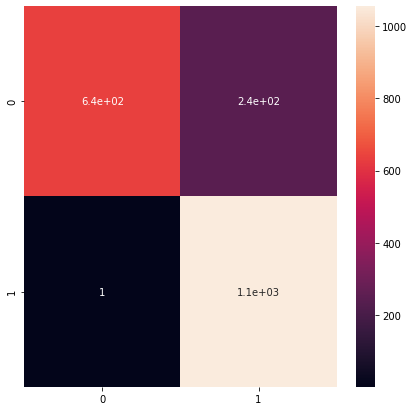

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       880
           1       0.81      1.00      0.90      1056

    accuracy                           0.87      1936
   macro avg       0.91      0.86      0.87      1936
weighted avg       0.90      0.87      0.87      1936



# TAREA #7: ENTENDER LA TEORÍA E INTUICIÓN DETRÁS DE RESUNET (SEGMENTACIÓN)

![alt text](https://drive.google.com/uc?id=11umTaVyb_ArSvhvUk3R4EhL8uDbaRqvD)

![alt text](https://drive.google.com/uc?id=12oM_qvqctXXVXzBwjwGFtwTwEYV4AUGD)

![alt text](https://drive.google.com/uc?id=19UPrhTof097bg8O3s4Mq9595bg9sKFpl)

![alt text](https://drive.google.com/uc?id=1QnvjtSGfRROJ68LLK9iBLvqqEZPxU-ZP)

# TAREA #8: CONSTRUIR UN MODELO DE SEGMENTACIÓN CON RESUNET

In [ ]:
# dividir los datos en datos de entrenamiento y de prueba

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [ ]:
# crear una lista separada para imageId, classId y rle para pasar al generador

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [ ]:
from utilities import DataGenerator

# Crear el generador de imágenes

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [ ]:
def resblock(X, f):
  

  # Hacemos una copia de la entrada
  X_copy = X

  # Path principal
  # Puedes leer más aquí: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Path corto
  # Puedes leer más aquí: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Añadimos el fichero de salida a partir de la combinación de path principal y el corto
  
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Función para upscale y concatenar los valores

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


## Función de pérdidas:
 
Necesitamos una función de pérdida personalizada para entrenar a este ResUNet: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [ ]:
%cd /content/drive/My Drive/Curso de Data Science para Empresas/6. Maintenance Department

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# usar la parada temprana para salir del entrenamiento si la pérdida de validación no disminuye incluso después de ciertas epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# guardar el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

Epoch 1/40
287/287 [==============================] - ETA: 0s - loss: 0.9339 - tversky: 0.0869
Epoch 00001: val_loss improved from inf to 0.87792, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 123s 430ms/step - loss: 0.9339 - tversky: 0.0869 - val_loss: 0.8779 - val_tversky: 0.1590
Epoch 2/40
287/287 [==============================] - ETA: 0s - loss: 0.7274 - tversky: 0.3430
Epoch 00002: val_loss improved from 0.87792 to 0.66480, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 119s 415ms/step - loss: 0.7274 - tversky: 0.3430 - val_loss: 0.6648 - val_tversky: 0.4178
Epoch 3/40
287/287 [==============================] - ETA: 0s - loss: 0.6317 - tversky: 0.4560
Epoch 00003: val_loss improved from 0.66480 to 0.60222, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 118s 411ms/step - loss: 0.6317 - tversky: 0.4560 - val_loss: 0.6022 - val_tversky: 0.4898
Ep

KeyboardInterrupt: ignored

In [ ]:
# Guardamos el modelo para uso futuro

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# TAREA #9: EVALUAR LA EFICACIA DEL MODELO DE SEGMENTACIÓN ENTRENADO

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Cargar el modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Datos del conjunto de test para la tarea de segmentación

test_df = pd.read_csv('test.csv')


In [ ]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [ ]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [ ]:
from utilities import prediction

# Hacemos la predicción
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


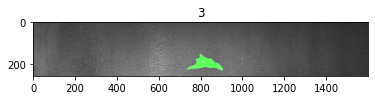

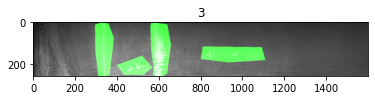

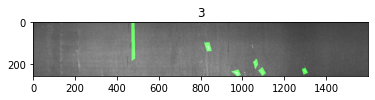

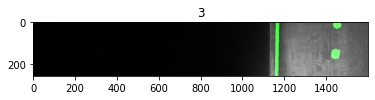

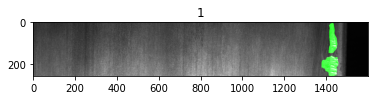

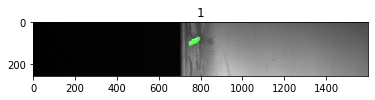

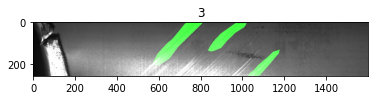

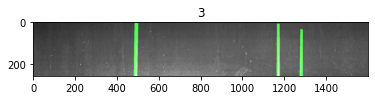

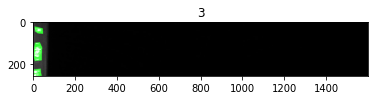

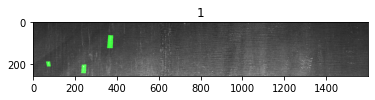

In [ ]:
# Vamos a mostrar las imágenes junto con sus máscaras originales (ground truth)
for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtener máscara para la imagen de rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

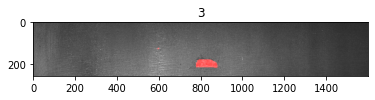

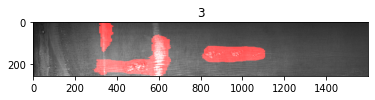

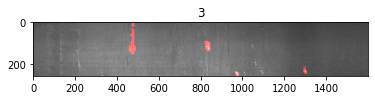

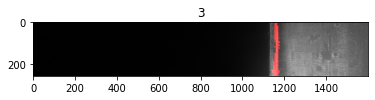

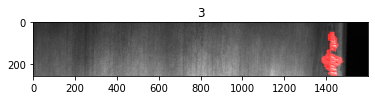

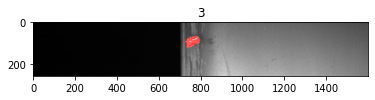

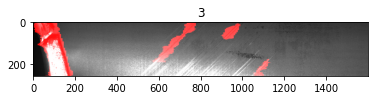

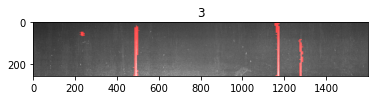

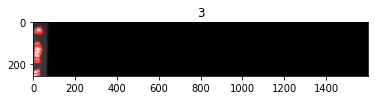

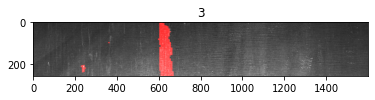

In [ ]:
# visualizar los resultados (predicciones del modelo)

directory = "train_images"

for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

   # Obtener máscara para la imagen de rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])
  
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)

# BUEN TRABAJO!!